# Backtest Config Example

## Getting some raw data

Before we start the notebook - as a once off we need to download some sample data for backtesting

For this notebook we will use Forex data from `histdata.com`, simply go to https://www.histdata.com/download-free-forex-historical-data/?/ascii/tick-data-quotes/ and select a Forex pair and one or more months of data to download.

Once you have downloaded the data, set the variable `DATA_DIR` below to the directory containing the data. By default it will use the users `Downloads` directory.

In [1]:
DATA_DIR = "~/Downloads/"

Run the cell below; you should see the files that you downloaded

In [2]:
import fsspec
fs = fsspec.filesystem('file')
raw_files = fs.glob(f"{DATA_DIR}/HISTDATA*")
assert raw_files, f"Unable to find any histdata files in directory {DATA_DIR}"
raw_files

['/Users/bradleymcelroy/Downloads/HISTDATA_COM_ASCII_AUDUSD_T202001.zip',
 '/Users/bradleymcelroy/Downloads/HISTDATA_COM_ASCII_AUDUSD_T202106',
 '/Users/bradleymcelroy/Downloads/HISTDATA_COM_ASCII_AUDUSD_T202106.zip',
 '/Users/bradleymcelroy/Downloads/HISTDATA_COM_ASCII_EURUSD_T202101',
 '/Users/bradleymcelroy/Downloads/HISTDATA_COM_ASCII_EURUSD_T202101.txt',
 '/Users/bradleymcelroy/Downloads/HISTDATA_COM_ASCII_EURUSD_T202101.zip']

## The Data Catalog

Next we will load this raw data into the data catalog. The data catalog is a central store for nautilus data, persisted in the [Parquet](https://parquet.apache.org) file format.

We have chosen parquet as the storage format for the following reasons:
- It performs much better than CSV/JSON/HDF5/etc in terms of compression (storage size) and read performance
- It does not require any separate running components (for example a database)
- It is quick and simple for someone to get up and running with

## Loading data into the catalog

We can load data from various sources into the data catalog using helper methods in the `nautilus_trader.persistence.external.readers` module. The module contains methods for reading various data formats (csv, json, txt), minimising the amount of code required to get data loaded correctly into the data catalog.

The Forex data from `histdata` is stored in csv/text format, with fields `timestamp, bid_price, ask_price`. To load the data into the catalog, we simply write a function that converts each row into a nautilus object (in this case, a `QuoteTick`). For this example, we will use the `TextReader` helper, which allows reading and applying a parsing function line by line.

Then, we simply instantiate a data catalog (passing in a directory where to store the data, by default we will just use the current directory) and pass our parsing function wrapping in the Reader class to `process_files`. We also need to know about which instrument this data is for; in this example, we will simply use one of the nautilus test helpers to create a Forex instrument.

It should only take a couple of minutes to load the data (depending on how many months)

In [3]:
import datetime
import pandas as pd

from nautilus_trader.persistence.catalog import DataCatalog
from nautilus_trader.persistence.external.core import process_files, write_chunk
from nautilus_trader.persistence.external.readers import TextReader

from nautilus_trader.model.data.tick import QuoteTick
from nautilus_trader.model.objects import Price, Quantity
from nautilus_trader.core.datetime import dt_to_unix_nanos


from tests.test_kit.providers import TestInstrumentProvider

In [4]:
def parser(line):
    ts, bid, ask, idx = line.split(b",")
    dt = pd.Timestamp(datetime.datetime.strptime(ts.decode(), "%Y%m%d %H%M%S%f"), tz='UTC')
    yield QuoteTick(
        instrument_id=AUDUSD.id,
        bid=Price.from_str(bid.decode()),
        ask=Price.from_str(ask.decode()),
        bid_size=Quantity.from_int(100_000),
        ask_size=Quantity.from_int(100_000),
        ts_event=dt_to_unix_nanos(dt),
        ts_init=dt_to_unix_nanos(dt),

    )

In [5]:
AUDUSD = TestInstrumentProvider.default_fx_ccy("AUD/USD")

catalog = DataCatalog(".")

process_files(
    glob_path=f"{DATA_DIR}/HISTDATA*202001*",
    reader=TextReader(line_parser=parser),
    catalog=catalog,
)
write_chunk(catalog, [AUDUSD]) # Also write our AUDUSD instrument to the catalog

[########################################] | 100% Completed | 44.6s


## Using the Data Catalog 

Once data has been loaded into the catalog, the `catalog` instance can be used for loading data into the backtest engine, or simple for research purposes. It contains various methods to pull data from the catalog, like `quote_ticks` (show below))

In [6]:
catalog.instruments()

,id,base_currency,quote_currency,price_precision,size_precision,price_increment,size_increment,lot_size,max_quantity,min_quantity,...,min_notional,max_price,min_price,margin_init,margin_maint,maker_fee,taker_fee,info,ts_init,ts_event
0,AUD/USD.SIM,AUD,USD,5,0,0.00001,1,1000,10000000,1000,...,1_000.00 USD,NaN,NaN,0.03,0.03,0.00002,0.00002,None,0,0


In [7]:
start = dt_to_unix_nanos(pd.Timestamp('2020-01-01', tz='UTC'))
end =  dt_to_unix_nanos(pd.Timestamp('2020-01-02', tz='UTC'))

catalog.quote_ticks(start=start, end=end)

,bid,bid_size,ask,ask_size,ts_event,ts_init,instrument_id
0,0.701370,100000,0.702130,100000,1577898010013000000,1577898010013000000,AUD/USD.SIM
1,0.701370,100000,0.701880,100000,1577898015267000000,1577898015267000000,AUD/USD.SIM
2,0.701370,100000,0.701790,100000,1577898054385000000,1577898054385000000,AUD/USD.SIM
3,0.701370,100000,0.701800,100000,1577898054665000000,1577898054665000000,AUD/USD.SIM
4,0.701370,100000,0.701780,100000,1577898060114000000,1577898060114000000,AUD/USD.SIM
...,...,...,...,...,...,...,...
11101,0.700180,100000,0.700270,100000,1577923150990000000,1577923150990000000,AUD/USD.SIM
11102,0.700180,100000,0.700270,100000,1577923170732000000,1577923170732000000,AUD/USD.SIM
11103,0.700180,100000,0.700270,100000,1577923170884000000,1577923170884000000,AUD/USD.SIM
11104,0.700190,100000,0.700290,100000,1577923186425000000,1577923186425000000,AUD/USD.SIM


## Running backtests

Nautilus has a top level object `BacktestRunConfig` that allows configuring a backtest in one place. It is a `Partialable` object which means it can be configured in stages; the benefits of which are reduced boilerplate code when creating multiple backtest runs (for example when doing some sort of grid search over parameters).

We can start partially configuring the config with just a Venue:

In [20]:
from nautilus_trader.backtest.config import BacktestRunConfig, BacktestVenueConfig, BacktestDataConfig, BacktestEngineConfig
from nautilus_trader.model.currencies import USD

# Create a `base` config object to be shared with all backtests
base = BacktestRunConfig(
    venues=[
        BacktestVenueConfig(
            name="SIM",
            venue_type="ECN",
            oms_type="HEDGING",
            account_type="MARGIN",
            base_currency="USD",
            starting_balances=["1000000 USD"],
        )
    ]
)
base

BacktestRunConfig(name=None, engine=None, venues=[BacktestVenueConfig(name='SIM', venue_type='ECN', oms_type='HEDGING', account_type='MARGIN', base_currency='USD', starting_balances=['1000000 USD'])], data=None, strategies=None)

Notice many of the fields are `None` - we can use the `BacktestRunConfig.check()` method to see which required fields remain

In [12]:
base.check()

We can continue to configure the backtest via `update`

The `data_config` arg allows adding multiple data types (quotes, trades, generic_data), but for one specific backtest run

In [25]:
import os

instrument = catalog.instruments(as_nautilus=True)[0]

data_config=[
    BacktestDataConfig(
        catalog_path=os.getcwd(),
        data_type=QuoteTick,
        instrument_id=instrument.id.value,
        start_time=1580398089820000000,
        end_time=1580504394501000000,
    )
]

config = base.update(
    data=data_config,
    engine=BacktestEngineConfig()
)

config

BacktestRunConfig(name=None, engine=BacktestEngineConfig(trader_id='BACKTESTER-000', log_level='INFO', cache=None, cache_database=None, data_engine=None, risk_engine=None, exec_engine=None, use_data_cache=False, bypass_logging=False, run_analysis=True), venues=[BacktestVenueConfig(name='SIM', venue_type='ECN', oms_type='HEDGING', account_type='MARGIN', base_currency='USD', starting_balances=['1000000 USD'])], data=[BacktestDataConfig(catalog_path='/Users/bradleymcelroy/projects/nautilus_trader_gh/examples/backtest/notebooks', data_type=<class 'nautilus_trader.model.data.tick.QuoteTick'>, catalog_fs_protocol=None, instrument_id='AUD/USD.SIM', start_time=1580398089820000000, end_time=1580504394501000000, filters=None, client_id=None)], strategies=None)

### Finally, we can perform a grid-search of some parameters by using the `replace` method, which returns a new copy of the config

Note here the `strategy` is actually a tuple of (`TradingStrategy` class, `kwargs` dict), as we can't (currently) serialize a trading strategy to send to dask workers.

In [36]:
from decimal import Decimal
from nautilus_trader.trading.config import ImportableStrategyConfig
from nautilus_trader.model.data.bar import BarSpecification
from nautilus_trader.model.enums import BarAggregation, PriceType


PARAM_SET = [
    {"fast_ema": 10, "slow_ema": 20},
    {"fast_ema": 20, "slow_ema": 30},
    {"fast_ema": 30, "slow_ema": 40},
]

configs = []
for params in PARAM_SET:
    strategies = [
        ImportableStrategyConfig(
            path="examples.strategies.ema_cross_simple.EMACross",
            config=dict(
                instrument_id=instrument.id,
                bar_spec=BarSpecification(15, BarAggregation.MINUTE, PriceType.BID),
                trade_size=Decimal(1_000_000),
                **params
            ),
        ),
    ]
    # Create the final config
    new = config.replace(strategies=strategies)
    
    configs.append(new)

You can also optionally assign a `name` to the config, otherwise an unique hash will be generated

### This creates 3 sets of parameters to run over

In [38]:
configs

[BacktestRunConfig(name=None, engine=BacktestEngineConfig(trader_id='BACKTESTER-000', log_level='INFO', cache=None, cache_database=None, data_engine=None, risk_engine=None, exec_engine=None, use_data_cache=False, bypass_logging=False, run_analysis=True), venues=[BacktestVenueConfig(name='SIM', venue_type='ECN', oms_type='HEDGING', account_type='MARGIN', base_currency='USD', starting_balances=['1000000 USD'])], data=[BacktestDataConfig(catalog_path='/Users/bradleymcelroy/projects/nautilus_trader_gh/examples/backtest/notebooks', data_type=<class 'nautilus_trader.model.data.tick.QuoteTick'>, catalog_fs_protocol=None, instrument_id='AUD/USD.SIM', start_time=1580398089820000000, end_time=1580504394501000000, filters=None, client_id=None)], strategies=[ImportableStrategyConfig(path='examples.strategies.ema_cross_simple.EMACross', source=None, config=TradingStrategyConfig(order_id_tag='000', oms_type='HEDGING'))]),
 BacktestRunConfig(name=None, engine=BacktestEngineConfig(trader_id='BACKTESTE

# Run the backtest

Finally, we can create a BacktestNode and run the backtest

In [42]:
from nautilus_trader.backtest.node import BacktestNode
node = BacktestNode()

In [45]:
task = node.build_graph(run_configs=configs)

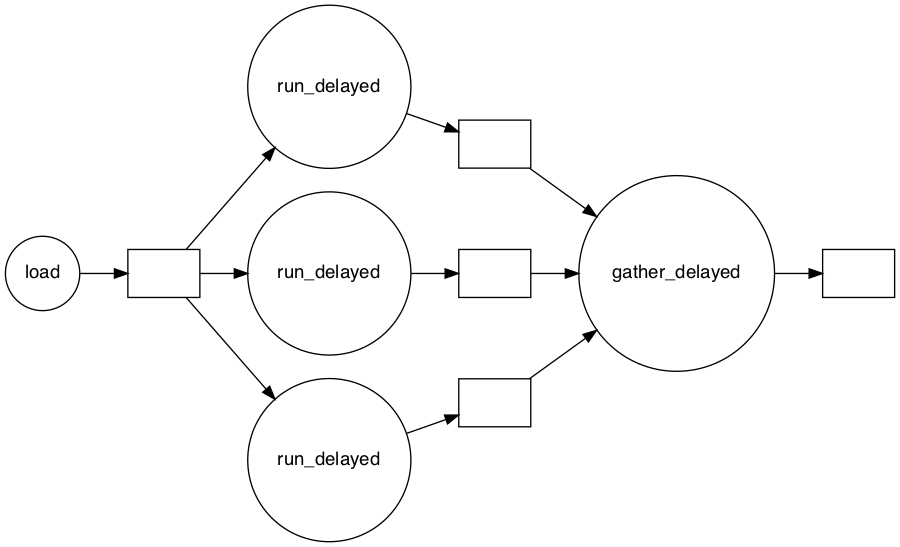

In [48]:
task.visualize(rankdir='LR')

#### Notice because our configs share the same data that only one instance of `load` is required

### Start up a local dask cluster to execute the graph

In [49]:
# Create a local dask client
from distributed import Client
client = Client(n_workers=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52258,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52391,Total threads: 4
Dashboard: http://127.0.0.1:52394/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:52263,


### Run the backtests!

In [50]:
results = task.compute()

distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function apply at 0x10c4ef8b0>, <function BacktestNode._run_delayed at 0x143c44820>, [<nautilus_trader.backtest.node.BacktestNode object at 0x141151f40>], (<class 'dict'>, [['name', 'backtest-336add69a8c2a55b653fbc6c4f9bc272'], ['venue_configs', [(<function apply at 0x10c4ef8b0>, <class 'nautilus_trader.backtest.config.BacktestVenueConfig'>, (), (<class 'dict'>, [['name', 'SIM'], ['venue_type', 'ECN'], ['oms_type', 'HEDGING'], ['account_type', 'MARGIN'], ['base_currency', 'USD'], ['starting_balances', ['1000000 USD']]]))]], ['input_data', [{'type': <class 'nautilus_trader.model.data.tick.QuoteTick'>, 'data': [QuoteTick(AUD/USD.SIM,0.671650,0.671730,100000,100000,1580398094275000000), QuoteTick(AUD/USD.SIM,0.671700,0.671760,100000,100000,1580398094907000000), QuoteTick(AUD/USD.SIM,0.671680,0.671760,100000,100000,1580398094957000000), QuoteTick(AUD/USD.SIM,0.671700,0.671760,100000,100000,15803980950590000

AssertionError: Path variable should be of the form: path.to.module:class

In [31]:
results

{'backtest-f6db99029a46bc85f9a43c84069aca95': {'account':                                  balance_USD venue
  timestamp                                         
  2020-01-30 20:15:00.275000+00:00   999986.58   SIM
  2020-01-31 00:15:01.969000+00:00   999893.16   SIM
  2020-01-31 00:15:01.969000+00:00   999879.74   SIM
  2020-01-31 01:00:00.016000+00:00   998806.30   SIM
  2020-01-31 01:00:00.016000+00:00   998792.86   SIM
  2020-01-31 03:15:00.104000+00:00   997959.43   SIM
  2020-01-31 03:15:00.104000+00:00   997946.00   SIM
  2020-01-31 05:00:01.939000+00:00   997022.56   SIM
  2020-01-31 05:00:01.939000+00:00   997009.12   SIM
  2020-01-31 07:00:00.116000+00:00   996275.69   SIM
  2020-01-31 07:00:00.116000+00:00   996262.26   SIM
  2020-01-31 13:45:00.288000+00:00   997638.86   SIM
  2020-01-31 13:45:00.288000+00:00   997625.46   SIM
  2020-01-31 15:30:00.972000+00:00   996948.68   SIM
  2020-01-31 15:30:00.972000+00:00   996962.07   SIM
  2020-01-31 20:59:54.501000+00:00   997035